In [353]:
family_sizes = [4]
#phase_dir = '../phased'
#data_dir = '../split_gen_miss'
phase_dir = '../phased_ssc'
data_dir = '../split_gen_miss_ssc'
chroms = range(2, 23)

In [354]:
monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
#print(monozygotic_multiple_families)

In [355]:
import numpy as np

all_positions = set()
family_to_chroms = defaultdict(set)

chroms = range(2, 23)
for chrom in chroms:
    print(chrom)

    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.phased.masked.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    inheritance_state = [int(x) for x in pieces[1:(1+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
                    all_positions.add((chrom, start_pos))
                    all_positions.add((chrom, end_pos))
                    family_to_chroms[family_key].add(chrom)
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'family size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)
    
pos_to_index = dict([(x, i) for i, x in enumerate(sorted(all_positions))])
max_index = len(pos_to_index)

families_to_include = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms) and k.split('.')[0] not in monozygotic_multiple_families])
if 'AU0897.AU0897202.AU0897201' in families_to_include:
    families_to_include.remove('AU0897.AU0897202.AU0897201')
#families_to_include = families_to_include & set(fams_with_many)
#families_to_include = families_to_include - set(fams_with_many)
print('Num families included', len(families_to_include))


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
Num families included 359


In [356]:
import numpy as np

all_positions = set()
family_to_individuals = dict()

for chrom in chroms:
    print(chrom)

    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf:
                next(famf) # skip header
                for line in famf:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include:
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            
            with open('%s/chr.%s.familysize.%d.phased.masked.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include:
                        inheritance_state = [int(x) for x in pieces[1:(1+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
                        all_positions.add((chrom, start_pos))
                        all_positions.add((chrom, end_pos))
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'family size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)
    
snp_positions = sorted(all_positions)
pos_to_index = dict([(x, i) for i, x in enumerate(snp_positions)])
snp_positions = np.asarray(snp_positions)
n = len(pos_to_index)
print('n', n)

family_to_index = dict([(x, i) for i, x in enumerate(family_to_individuals.keys())])
m = 4*len(family_to_index)
print('m', m)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
n 310854
m 1436


In [357]:
from collections import defaultdict

# load deletions
deletions = np.zeros((m, max_index), dtype=np.int8)-1

for chrom in chroms:
    print(chrom)
    for j in family_sizes:
        try:
            # load deletions
            with open('%s/chr.%s.familysize.%d.phased.masked.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include:
                        inheritance_state = [int(x) for x in pieces[1:(1+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
                        start_index, end_index = pos_to_index[(chrom, start_pos)], pos_to_index[(chrom, end_pos)]
                        length = end_pos - start_pos + 1

                        deletions[4*family_to_index[family_key], start_index:(end_index+1)] = inheritance_state[0]
                        deletions[(4*family_to_index[family_key])+1, start_index:(end_index+1)] = inheritance_state[1]
                        deletions[(4*family_to_index[family_key])+2, start_index:(end_index+1)] = inheritance_state[2]
                        deletions[(4*family_to_index[family_key])+3, start_index:(end_index+1)] = inheritance_state[3]

                    
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'fammily size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


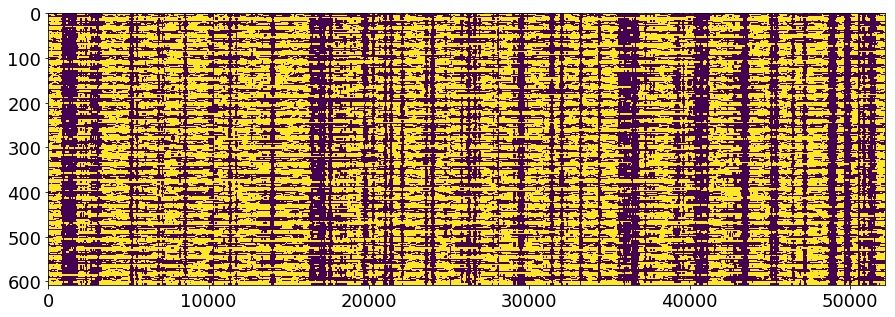

In [330]:
change_indices = np.where(np.any(deletions[:, 1:] != deletions[:, :-1], axis=0))[0]

plt.figure(figsize=(15, 5))
plt.imshow(deletions[:, change_indices], aspect='auto', vmin=-1, vmax=1)
plt.show()

In [358]:
del_starts = np.where((deletions[:, :-1] != 0) & (deletions[:, 1:] == 0))
del_ends = np.where((deletions[:, :-1] == 0) & (deletions[:, 1:] != 0))
del_lengths = snp_positions[del_ends[1], 1]-snp_positions[del_starts[1]+1, 1]+1

opt_del_starts = []
opt_del_ends = []
total_bp_deleted = np.zeros((m,), dtype=int)

for ind_index, start, ind_index2, end in zip(del_starts[0], del_starts[1], del_ends[0], del_ends[1]):
    if ind_index == ind_index2:
        for i in range(start+1):
            if (deletions[ind_index, start-i] == 1) or (snp_positions[start-i, 0] != snp_positions[start-i+1, 0]):
                break
        opt_del_starts.append(start-i+1)
        
        for i in range(1, n-end-2):
            if (deletions[ind_index, end+i] == 1) or (snp_positions[end+i, 0] != snp_positions[end+i-1, 0]):
                break
        opt_del_ends.append(end+i-1)
        total_bp_deleted[ind_index] += (snp_positions[end, 1]-snp_positions[start+1, 1]+1)
    else:
        print('Error', in_index, ind_index2, start, end)
        
opt_del_lengths = snp_positions[opt_del_ends][:, 1]-snp_positions[opt_del_starts][:, 1]+1


min length 1 max length 5213753 num 9138 median 19344.0
min length 148 max length 32957349 num 9138 median 21719.0


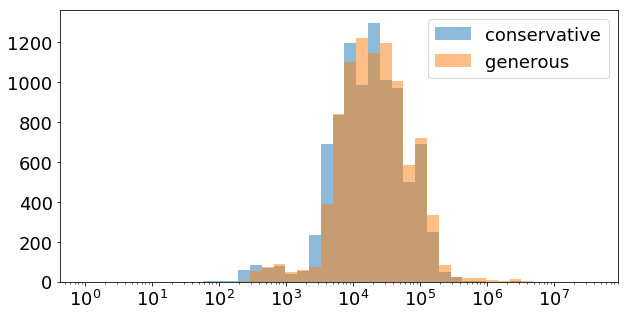

In [359]:
import math
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
base = 1.5
max_length = max(opt_del_lengths) 
min_length = min(del_lengths) 
print('min length', min(del_lengths) , 'max length', max(del_lengths) , 'num', len(del_lengths), 'median', np.median(del_lengths))
print('min length', min(opt_del_lengths) , 'max length', max(opt_del_lengths) , 'num', len(opt_del_lengths), 'median', np.median(opt_del_lengths))

plt.hist(del_lengths, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5, label='conservative')
plt.hist(opt_del_lengths, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5, label='generous')

plt.gca().set_xscale("log")
plt.legend()
plt.show()

Percent 1 0.0006565988181221273
Percent 1 0.004049026045086452
min length 1 max length 3552975 num 9138 median 575.5
min length 1 max length 32932520 num 9138 median 580.0


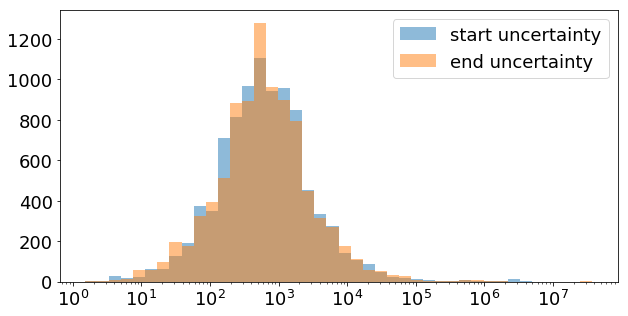

In [360]:
plt.figure(figsize=(10, 5))
base = 1.5

start_unknown = snp_positions[del_starts[1]+1, 1]-snp_positions[opt_del_starts, 1]+1
end_unknown = snp_positions[opt_del_ends, 1]-snp_positions[del_ends[1], 1]+1

print('Percent 1', len([x for x in start_unknown if x == 1])/len(start_unknown))
print('Percent 1', len([x for x in end_unknown if x == 1])/len(end_unknown))

max_length = max(max(start_unknown), max(end_unknown))
min_length = min(min(start_unknown), min(end_unknown))
print('min length', min(start_unknown) , 'max length', max(start_unknown) , 'num', len(start_unknown), 'median', np.median(start_unknown))
print('min length', min(end_unknown) , 'max length', max(end_unknown) , 'num', len(end_unknown), 'median', np.median(end_unknown))

plt.hist(start_unknown, bins=[pow(base, i) for i in range(1, math.ceil(math.log(max_length, base))+1)], alpha=0.5, label='start uncertainty')
plt.hist(end_unknown, bins=[pow(base, i) for i in range(1, math.ceil(math.log(max_length, base))+1)], alpha=0.5, label='end uncertainty')

plt.gca().set_xscale("log")
plt.legend()
plt.show()

<Figure size 576x360 with 0 Axes>

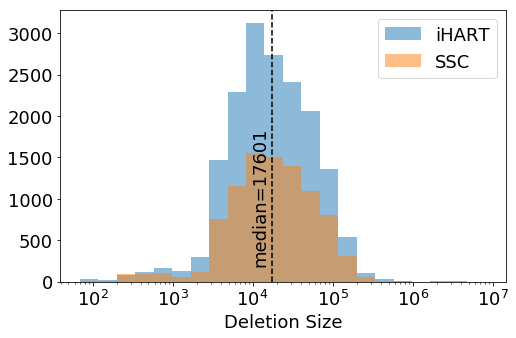

In [363]:
import math
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.7
max_length = max(np.concatenate((ihart_del_lengths,del_lengths)))
min_length = min(np.concatenate((ihart_del_lengths,del_lengths)))
med_length = np.median(np.concatenate((ihart_del_lengths,del_lengths)))

#print('min length', min(del_lengths) , 'max length', max(del_lengths) , 'num', len(del_lengths), 'median', med_length)
#print('min length', min(opt_del_lengths) , 'max length', max(opt_del_lengths) , 'num', len(opt_del_lengths), 'median', np.median(opt_del_lengths))

plt.hist(ihart_del_lengths, bins=[pow(base, i) for i in range(math.floor(math.log(100, base)), math.ceil(math.log(max_length, base))+1)], alpha=0.5, label='iHART')
plt.hist(del_lengths, bins=[pow(base, i) for i in range(math.floor(math.log(100, base)), math.ceil(math.log(max_length, base))+1)], alpha=0.5, label='SSC')

plt.gca().set_xscale("log")
plt.xlabel('Deletion Size')
plt.axvline(med_length, color='black', linestyle='--')
plt.text(med_length-8000,1700,'median=%d'%med_length,rotation=90)
plt.legend()
plt.show()

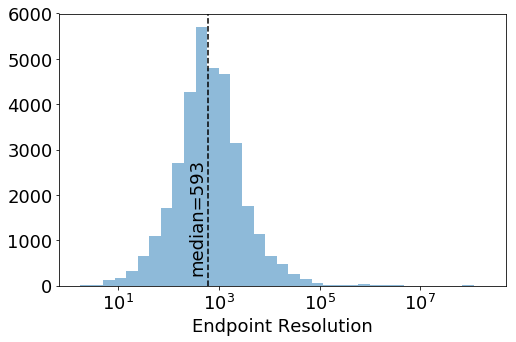

In [351]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.7

start_unknown = snp_positions[del_starts[1]+1, 1]-snp_positions[opt_del_starts, 1]+1
end_unknown = snp_positions[opt_del_ends, 1]-snp_positions[del_ends[1], 1]+1

#print('Percent 1', len([x for x in start_unknown if x == 1])/len(start_unknown))
#print('Percent 1', len([x for x in end_unknown if x == 1])/len(end_unknown))

max_length = max(max(start_unknown), max(end_unknown))
min_length = min(min(start_unknown), min(end_unknown))
med_length = np.median(np.concatenate((start_unknown, end_unknown)))
#print('min length', min(start_unknown) , 'max length', max(start_unknown) , 'num', len(start_unknown), 'median', med_length)
#print('min length', min(end_unknown) , 'max length', max(end_unknown) , 'num', len(end_unknown), 'median', np.median(end_unknown))

plt.hist(np.concatenate((ihart_start_unknown, end_unknown)), bins=[pow(base, i) for i in range(1, math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.hist(np.concatenate((start_unknown, end_unknown)), bins=[pow(base, i) for i in range(1, math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")
plt.xlabel('Endpoint Resolution')
plt.axvline(med_length, color='black', linestyle='--')
plt.text(med_length-350,2500,'median=%d'%med_length,rotation=90)
plt.show()

min length 5743 max length 6940954 avg 221713.96833333332 median 173103.5


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


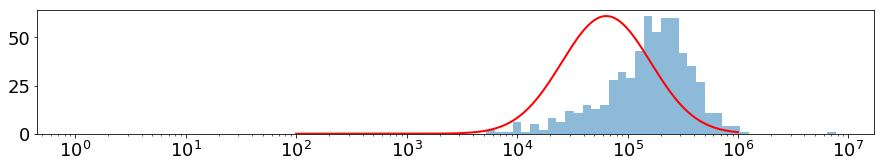

In [329]:
plt.figure(figsize=(15, 5))

# total bases deleted
base = 1.2

total_bp_deleted_log = [x for x in total_bp_deleted if x != 0]
max_length = max(total_bp_deleted_log) 
min_length = min(total_bp_deleted_log) 
print('min length', min_length, 'max length', max_length, 'avg', np.mean(total_bp_deleted_log), 'median', np.median(total_bp_deleted_log))


ax1 = plt.subplot(2, 1, 1)
plt.hist(total_bp_deleted_log, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
#plt.gca().set_xscale("log")

#plt.subplot(2, 1, 2, sharex=ax1)
mu, sigma = np.mean(np.log(total_bp_deleted_log)), np.std(np.log(total_bp_deleted_log))
x = np.linspace(0, 1000000, 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/ (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, 14000000*pdf, linewidth=2, color='r')
plt.gca().set_xscale("log")
#ax2 = ax1.twinx()
#ax2.hist(ihart_total_bp_deleted, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5, color='red')

plt.show()

In [352]:
ihart_del_lengths = del_lengths
ihart_start_unknown = start_unknown
ihart_end_unknown = end_unknown

In [275]:
ihart_total_bp_deleted = total_bp_deleted

In [217]:
import scipy.stats as st

#ssc_total_bp_deleted = total_bp_deleted

print(st.ttest_ind(total_bp_deleted, ssc_total_bp_deleted, axis=0, equal_var=False))

Ttest_indResult(statistic=-27.674780893837102, pvalue=4.929679384985317e-144)
